# Stock Trading For Dummies (With Keras)
*By Quentin Baker*
## Vision
I will use Keras' *Long short-term Memory* layers to build a Recurrant Neural Network (RNN) that, given historic stock data, can produce a model that will predict stock performance going forward. **I expect the results will not be very useful.** I am really interested in studying *why* most ML systems focused on the stock market fail over large periods of time.

### Background
The idea for this project came from an xkcd comic, #1570, titled **Engineer Syllogism**.  
![xkcd comic](https://imgs.xkcd.com/comics/engineer_syllogism.png)

This is a nice high-level explaination of a phenomenon I'd like to explore more in depth--namely, that machine learning and AI have inherent design incompatibilities with the irrational human-driven behaviour of the stock market. [Not to say][1] [this hasn't been tried][2] [many, *many* times][3]. Finance quant and mathematical expert Zachary David had the following to say about Machine Learning in Markets:

>Academic finance literature naively applying machine learning (ML) and artificial neural network (ANN) techniques to market price prediction is a dumb farce. While this probably won’t surprise anyone who has done a paper replication in the past 6+ years, despite all of the advancements in algorithms and hardware, and despite all of the new domains ANN’s have conquered, financial academics still insist on throwing feces at the wall. [[Source]][4]

[1]:https://jspauld.com/post/35126549635/how-i-made-500k-with-machine-learning-and-hft#_=_
[2]:http://eugenezhulenev.com/blog/2014/11/14/stock-price-prediction-with-big-data-and-machine-learning/
[3]:https://www.microsoft.com/developerblog/2017/12/04/predicting-stock-performance-deep-learning/
[4]:http://zacharydavid.com/2017/08/06/fitting-to-noise-or-nothing-at-all-machine-learning-in-markets/

### Implementation
#### Data Sourcing and Prep
I was going to use a test set from [quandl][5] but later found a much larger stock market dataset on [kaggle][6]. This data came in a large folder of `.txt` files containing the data as comma separated values. I built [a quick python ultity](https://github.com/Qrbaker/cs344/blob/master/project/stock_data_frame_builder.py) to process the data into one massive (~800MB) zipped CSV file, using Pandas. 

[5]:https://www.quandl.com/
[6]:https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs


#### Modeling
The initial version of this work was going to use embedding, but the more I researched, the more examples I found of NNs using LSTM layers to directly predict a given stock's performance. There was a very interesting implementation that inspired me: A Blog post titled ['Predicting Stock Price with LSTM'][7] with an associated [GitHub repository][8].

The premise is as follows: Convert this data into a form of *supervised learning* by using a single data point `n` as the label, and the previous `i` days as training data. In simpler terms, ask the NN to use the previous `i` days of data to predict `n`.

After reading through this, I decided to try building a more generalized system that could do a similar analysis, but on any stock ticker in my Data.

I actually built my NN model entirely in a Jupyter Notebook first so I could more easily follow my results and see plots.I [kept it in the project directory](https://github.com/Qrbaker/cs344/blob/master/project/inital_implemenation.ipynb) for historic purposes, as it is useful to follow the thought process and understand the final class. 

From there, I developed a class, `StockModel`, that abstracts away a lot of the set up work. It is comprised of an initializer, plus 4 primary methods:

* `__init__(self, stock_data="__DEFAULT__", look_back=30, verbose=False)`

The initializer, run without any arguments, will default to my stock data, though you can pass it any Pandas DataFrame with the appropriate columns (see the project README for spesifics). It will look back approximately 1 month, and will not print any info.

* `select_stock(self,ticker)`

This will select and return a dataframe with all \['ticker'\] columns that match "ticker". As all tickers are only upper-case letters, this method first converts the argument into all uppercase. If there is no match, a warning will print, and an empty DataFrame will be returned.

* `prep_data(self, stock_df, stock_feature='Close')`

This will select the feature we want to predict. It will produce a new DataFrame with just the selected feature, and automatically split it into training and testing sets; 4/5ths for training and 1/5th for testing, respectively. Currently this is hard-coded, but I'd like to make this an argument. This does not return anything, instead storing the data in class variables (accessable with `StockData.testing_values()` and `StockData.training_values()`).
* `build_model(self, epochs=5, batch_size=32)`

Using the class variables set up by prep_data, a Keras Model is now trained. It contains 3 LSTM layers, followed by a BatchNormalization layer, and finally passed into a Dense layer with 1 output neuron, which will be the expected price. The resulting model is stored as a class variable.

* `predict_on_data(self)`

This method takes whatever the model generated by build_model is and applys it to the test data. It returns an array of predicted values.

[7]:https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944
[8]:https://github.com/DarkKnight1991/Stock-Price-Prediction

### Results
This is the interesting portion. Below I initialize a StockModel, select for AAPL (Apple, Inc.) and train a model looking back 500 days.

In [1]:
import pandas as pd
import numpy as np
from keras import models
from keras import layers
from stock_model import StockModel

# Hides all the tensorFlow warnings about deprecated methods used by Keras
import os
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


In [2]:
my_model = StockModel(look_back=500,verbose=True)

===Initialized StockModel===
	Looking back 500 days.


In [12]:
apple_stock = my_model.select_stock('AAPL')

my_model.prep_data(apple_stock)
predictions = my_model.predict_on_data()

	Selected Stock AAPL
              Open         High          Low        Close        Volume
count  8364.000000  8364.000000  8364.000000  8364.000000  8.364000e+03
mean     22.284350    22.495867    22.054244    22.281018  1.066416e+08
std      37.763402    38.057733    37.447432    37.764469  9.935187e+07
min       0.233050     0.235640     0.230510     0.230510  0.000000e+00
25%       1.137100     1.164200     1.112800     1.137100  4.384365e+07
50%       1.632800     1.663400     1.600600     1.628250  7.481383e+07
75%      23.739000    23.930500    23.335750    23.694500  1.320534e+08
max     175.110000   175.610000   174.270000   175.610000  2.069770e+09
Prepared Data using feature "Close".
             Close
Date              
2011-03-16  42.261
2011-03-17  42.854
2011-03-18  42.346
2011-03-21  43.452
2011-03-22  43.696


In [3]:
my_model.build_model(epochs=10)

	Selected Stock AAPL
              Open         High          Low        Close        Volume
count  8364.000000  8364.000000  8364.000000  8364.000000  8.364000e+03
mean     22.284350    22.495867    22.054244    22.281018  1.066416e+08
std      37.763402    38.057733    37.447432    37.764469  9.935187e+07
min       0.233050     0.235640     0.230510     0.230510  0.000000e+00
25%       1.137100     1.164200     1.112800     1.137100  4.384365e+07
50%       1.632800     1.663400     1.600600     1.628250  7.481383e+07
75%      23.739000    23.930500    23.335750    23.694500  1.320534e+08
max     175.110000   175.610000   174.270000   175.610000  2.069770e+09
Prepared Data using feature "Close".
             Close
Date              
2011-03-16  42.261
2011-03-17  42.854
2011-03-18  42.346
2011-03-21  43.452
2011-03-22  43.696
Epoch 1/10
6191/6191 [==============================] - 153s 25ms/step - loss: 26.9858
Epoch 2/10
6191/6191 [==============================] - 183s 30ms/step - l

Here's a graph showing predicted versus actual over a 70-day period. It looks pretty good, right?

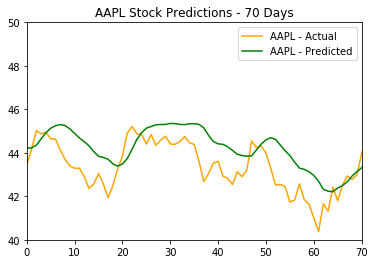

In [13]:
import matplotlib.pyplot as plt
plt.plot(my_model.testing_values, color = 'orange', label = 'AAPL - Actual')
plt.plot(predictions, color = 'green', label = 'AAPL - Predicted')
plt.title('AAPL Stock Predictions - 70 Days')
plt.legend()

# Limit Axes
axes = plt.gca()
axes.set_xlim([0,70])
axes.set_ylim([40,50])
plt.show()

Well... hang on. Here's the full 500-day period:

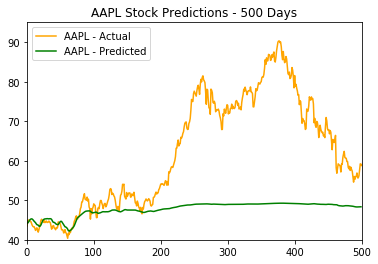

In [5]:
plt.plot(my_model.testing_values, color = 'orange', label = 'AAPL - Actual')
plt.plot(predictions, color = 'green', label = 'AAPL - Predicted')
plt.title('AAPL Stock Predictions - 500 Days')
plt.legend()

# Limit Axes
axes = plt.gca()
axes.set_xlim([0,500])
axes.set_ylim([40,95])
plt.show()

This reveals the first flaw of 3 I will show. This what I call a flaw of expected continutiy; basically that the model works okay if the data going forward is at least in the ballpark of previous data.

It turns out that this data starts at March 2011. Look at the full stock history of AAPL below:

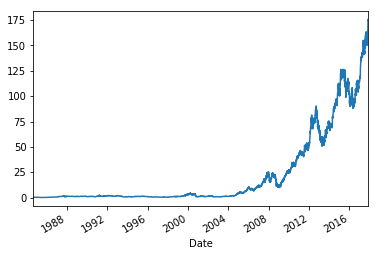

In [6]:
apple_stock.plot(y='Close',legend=False)

Historically, Apple had done okay, with a big rise (and subsequent drop) post 2008 recession. But it hadn't gone *bonkers* yet. This means that the NN could not predict the rise of Apple to becoming the world's most valuble company.

Let's try another stock, using the same model. We can easily do this by selecting and predicting a new stock, but not training a new model:

In [7]:
ford_stock = my_model.select_stock('F')

my_model.prep_data(ford_stock)

ford_predictions = my_model.predict_on_data()

	Selected Stock F
               Open          High           Low         Close        Volume
count  10305.000000  10305.000000  10305.000000  10305.000000  1.030500e+04
mean       6.981663      7.070698      6.884555      6.976319  2.172427e+07
std        5.641476      5.717214      5.565788      5.639187  3.737053e+07
min        0.212770      0.220660      0.212770      0.212770  0.000000e+00
25%        2.056900      2.088200      2.033300      2.056900  2.667947e+06
50%        6.186100      6.264900      6.107300      6.170300  5.385510e+06
75%       11.010000     11.118000     10.875000     11.001000  2.856602e+07
max       24.950000     25.279000     24.168000     24.973000  6.862608e+08
Prepared Data using feature "Close".
             Close
Date              
2009-08-31  5.9891
2009-09-01  5.7051
2009-09-02  5.5397
2009-09-03  5.8945
2009-09-04  5.8550


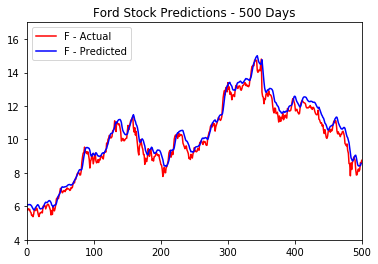

In [8]:
plt.plot(my_model.testing_values, color = 'red', label = 'F - Actual')
plt.plot(ford_predictions, color = 'blue', label = 'F - Predicted')
plt.title('Ford Stock Predictions - 500 Days')
plt.legend()

# Limit Axes
axes = plt.gca()
axes.set_xlim([0,500])
axes.set_ylim([4,17])
plt.show()

Again, not too bad (especially considering this trained on a different stock completely), and this time it actually tracked the full 500 days quite well! So what's the problem here? 

I actually found this stock shows the fallacy of working too well! First of all, the Y scale is different; Ford is more stable and overall trades within a narrower band.

Additionally, consider if we hadn't seen the AAPL example, it would be tempting to go put down a lot of money on Ford stock, then sell at ~350 days. But what if we tried this on AAPL stock? We migh've seen the prediction line alone and sold at 180 days when it went down, and subsequently missed a massive profit.

Finally, Lets look at how Microsoft (MSFT) faired.

In [14]:
microsoft_stock = my_model.select_stock('MSFT')

my_model.prep_data(microsoft_stock)
msft_predictions = my_model.predict_on_data()

	Selected Stock MSFT
              Open         High          Low        Close        Volume
count  7983.000000  7983.000000  7983.000000  7983.000000  7.983000e+03
mean     18.977859    19.187219    18.773635    18.984698  7.945800e+07
std      16.416068    16.552604    16.277882    16.424012  5.214889e+07
min       0.067200     0.067200     0.067200     0.067200  0.000000e+00
25%       2.113300     2.155100     2.079700     2.113300  4.910587e+07
50%      20.462000    20.697000    20.251000    20.469000  7.059385e+07
75%      25.475000    25.754000    25.233000    25.483500  9.734927e+07
max      84.770000    86.200000    84.082500    84.560000  1.371331e+09
Prepared Data using feature "Close".
             Close
Date              
2011-07-05  21.971
2011-07-06  22.220
2011-07-07  22.598
2011-07-08  22.724
2011-07-11  22.478


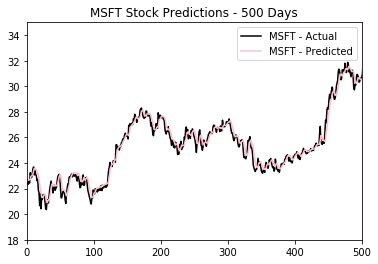

In [15]:
plt.plot(my_model.testing_values, color = 'black', label = 'MSFT - Actual')
plt.plot(msft_predictions, color = 'pink', label = 'MSFT - Predicted')
plt.title('MSFT Stock Predictions - 500 Days')
plt.legend()

# Limit Axes
axes = plt.gca()
axes.set_xlim([0,500])
axes.set_ylim([18,35])
plt.show()

Here, MSFT shows the most dangerous failure: Lag. Notice how the prediction looks good, but on closer inspection... 

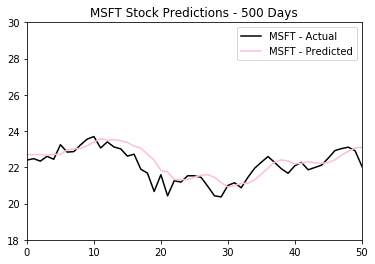

In [17]:
plt.plot(my_model.testing_values, color = 'black', label = 'MSFT - Actual')
plt.plot(msft_predictions, color = 'pink', label = 'MSFT - Predicted')
plt.title('MSFT Stock Predictions - 500 Days')
plt.legend()

# Limit Axes
axes = plt.gca()
axes.set_xlim([0,50])
axes.set_ylim([18,30])
plt.show()

The major movements are offset, happening *after* the stock has already gone up or down!

This offset is a big problem for NNs and arises whenever we try to predict large periods of time. This lag is a large contributor to why most automated trading is not long-term value investing, but rather [High-frequency Trading][HFT].

[HFT]:https://en.wikipedia.org/wiki/High-frequency_trading

### Implications

#### LSTMs are really effective
So, what are we left with? Well, I'd like to say I was actually surprised at how well this model worked. This is due in a large part to the discovery of Keras' LSTM layer. This layer is really spescial because it is a *gated* recurrent layer, which has special input gates (sort of like a logic gate). These gates include input and output, but also a third "forget" gate that allows LSTMs to effectively contain extra information outside of the normal error-backpropagtion flow, which helps mitigate the vanishing gradient problem.[Source][LSTM].



[LSTM]:https://skymind.ai/wiki/lstm#long

#### I still wouldn't put my money on this
Cool tech aside, I would not turn this model into an investing platform as it currently is. In fact, its partly due to how good the predictions look that so many people get sucked into this trap. [Here's one claimed success][500k], earning 500,000 USD using ML + HFT, but several people brought issue to this in a [discussion on the article][hn-500]. Here's the top comment (emphasis added):

> This is just glorified gambling. I am not sure what special insight or advantage he had, other than his own model. Every trader has a model.  
It could have easily been called "how i lost 500k with machine learning". Like gambling, it's easy to manipulate statistics to show that you did well in some period of time.  
I worked for a large investment bank about 10 years ago, writing trading programs for quant traders who were market makers. **The quants called guys like him "retail" investors and they gleefully picked off all those trades.** It's how they made all their money.  
So, everyone else, beware of making this a case study in how to make lots of money really fast. **You are more likely to lose money.** 

[500k]:http://jspauld.com/post/35126549635/how-i-made-500k-with-machine-learning-and-hft
[hn-500]:https://news.ycombinator.com/item?id=4748624


#### Looking at other approaches

##### LSTM
There are similar approaches using LSTM online; I rather dissapointedly discovered over [600 repositories on GitHub matching the query "lstm stock"][gh-query]. I like the simple summation on the repo made by one [Tenica Lee][lee]:
> **Does it work?**  
Not really, current results aren't much better than chance. The data might be too noisy for this method, or there might be something wrong in the code or model.

I actually think my model is more successful than random, but as I noted above, I would not go as far as investing based on the results.

##### Real-time Analysis
Most of the "successful" approaches you will read about online straddle the line between algorithmic trading and HFT. A less naive (in the sense of the model, not of me) approach to ML stock price prediction is explained in this [blog post bu Eugene Zhulenev, a Google Developer that actually works on TensorFlow directly][ez-blog]. In his example, he supposes a model trained not on daily data, but an up-to-the-*nanosecond* streaming dataframe of a raw order log for market trades. This model looks at the price, volume, and "direction" of each log entry, which means the data is able to relate a "pressure", in the spread of buy/sell orders. 

Eugene was able to successfully predict data ~70% of the time with this set-up. The HUGE caveat here is access: this data is much more granular, but is also unavalible to the average person. Real-time data services don't even list prices; they merely have an option to ["request more information"][rq]. And as they say, "if you have to ask, you can't afford it."


[gh-query]:https://github.com/search?q=lstm+stock
[lee]:https://github.com/tencia/stocks_rnn
[ez-blog]:http://eugenezhulenev.com/blog/2014/11/14/stock-price-prediction-with-big-data-and-machine-learning/
[rq]:https://www.theice.com/market-data/desktop-solutions/trade

### Conclusion

In closing, consider Ecclesiastes 1:9 (NKJV):
>That which has been is what will be,  
That which is done is what will be done,  
And there is nothing new under the sun.

It might be that no one has tried a given strategy for making money. But in this area, with so much value on the line, stop and think: is my python-based model, cobbled together over a week, doing something that Ph.Ds with billions in backing haven't considered?

ML is *powerful*. It certainly can do things that we previously could only dream of. But it is still a dumb model that will only produce what it is spesified to. I would caution people who rely on "AI" without at least understanding the high-level stuff, because as my code has shown, its easier than ever to build. 

One of the most powerful results from this RNN could be causing a person to lose a lot of money. And we as software developers should not sit idly by. Dr. Kathy O'Neil, a former Wall Street Quant, has the following to say:

>If we back away from them and treat mathematical models as a neutral and inevitable force, like the weather or the tides, we abdicate our responsibility. And the result, as we’ve seen, is WMDs that treat us like machine parts in the workplace, that blackball employees and feast on inequities.

As a Christian Programmer, Christian coming first, I belive we should consider the ethical and biblical, in all areas of life. After this project, I believe it more than ever.

### Bibliography
Nayak, A. (2019, March 18). Predicting Stock Price with LSTM. Retrieved from   
&nbsp;&nbsp;&nbsp;&nbsp;https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944 

A Beginner's Guide to LSTMs and Recurrent Neural Networks. (n.d.). Retrieved from   
&nbsp;&nbsp;&nbsp;&nbsp;https://skymind.ai/wiki/lstm#long

O'Neil, C. (2016). Weapons of Math Destruction: How Big Data Increases Inequality and   
&nbsp;&nbsp;&nbsp;&nbsp;Threatens Democracy. New York, NY: Broadway Books. 

